# Title
### Analyzing the knowledge of users using the degree of study time for goal materials and exam performances of goal objects as predictors. 

# Introduction

Academic success is often measured by students’ exam performance and test scores. While a seemingly positive correlation exists between study time and exam performance, this relationship is complex. It can easily be influenced by various factors, such as material difficulty, previous knowledge, teaching methods, learning styles, working memory and environment. Long study hours generally result in better exam performance and higher grades because students commit time to review the material and concepts, which increases confidence and understanding during the exam. Therefore, this project will aim to answer the question: is there a definite relationship between the degree of study time and exam performance? The data set used in this research is derived from the “User Knowledge Modeling Data Set,” which recorded real data on students’ knowledge level of Electrical DC Machines. There are a total of six attributes, with UNS (the knowledge level of the user) containing four different variables(very low, High, Low and Middle).


# Methods & Results

In [120]:
### Run this cell before continuing. 
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)
library(readxl)

In [121]:
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00257/Data_User_Modeling_Dataset_Hamdi%20Tolga%20KAHRAMAN.xls", 
              dest = "userknowledge_training.xls")
training_data <- read_excel("userknowledge_training.xls", sheet = 2) %>%
    select(-c(7, 8, 9))
training_data

New names:
• `` -> `...7`
• `` -> `...8`


STG,SCG,STR,LPR,PEG,UNS
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0.00,0.00,0.00,0.00,0.00,very_low
0.08,0.08,0.10,0.24,0.90,High
0.06,0.06,0.05,0.25,0.33,Low
⋮,⋮,⋮,⋮,⋮,⋮
0.54,0.82,0.71,0.29,0.77,High
0.50,0.75,0.81,0.61,0.26,Middle
0.66,0.90,0.76,0.87,0.74,High


In [122]:
training_data <- select(training_data, STG, PEG, UNS)
#STG (The degree of study time for goal object materails)
#PEG (The exam performance of user for goal objects)
#UNS (The knowledge level of user)
training_data

STG,PEG,UNS
<dbl>,<dbl>,<chr>
0.00,0.00,very_low
0.08,0.90,High
0.06,0.33,Low
⋮,⋮,⋮
0.54,0.77,High
0.50,0.26,Middle
0.66,0.74,High


In [123]:
training_data_summary<-training_data|>
     group_by(UNS)|>
     summarize(STG_mean = mean(STG), PEG_mean = mean(PEG))|>
     arrange(desc(PEG_mean))
training_data_summary

UNS,STG_mean,PEG_mean
<chr>,<dbl>,<dbl>
High,0.4216508,0.77253968
Middle,0.3999773,0.54238636
Low,0.3211446,0.23762651
very_low,0.3057917,0.09083333


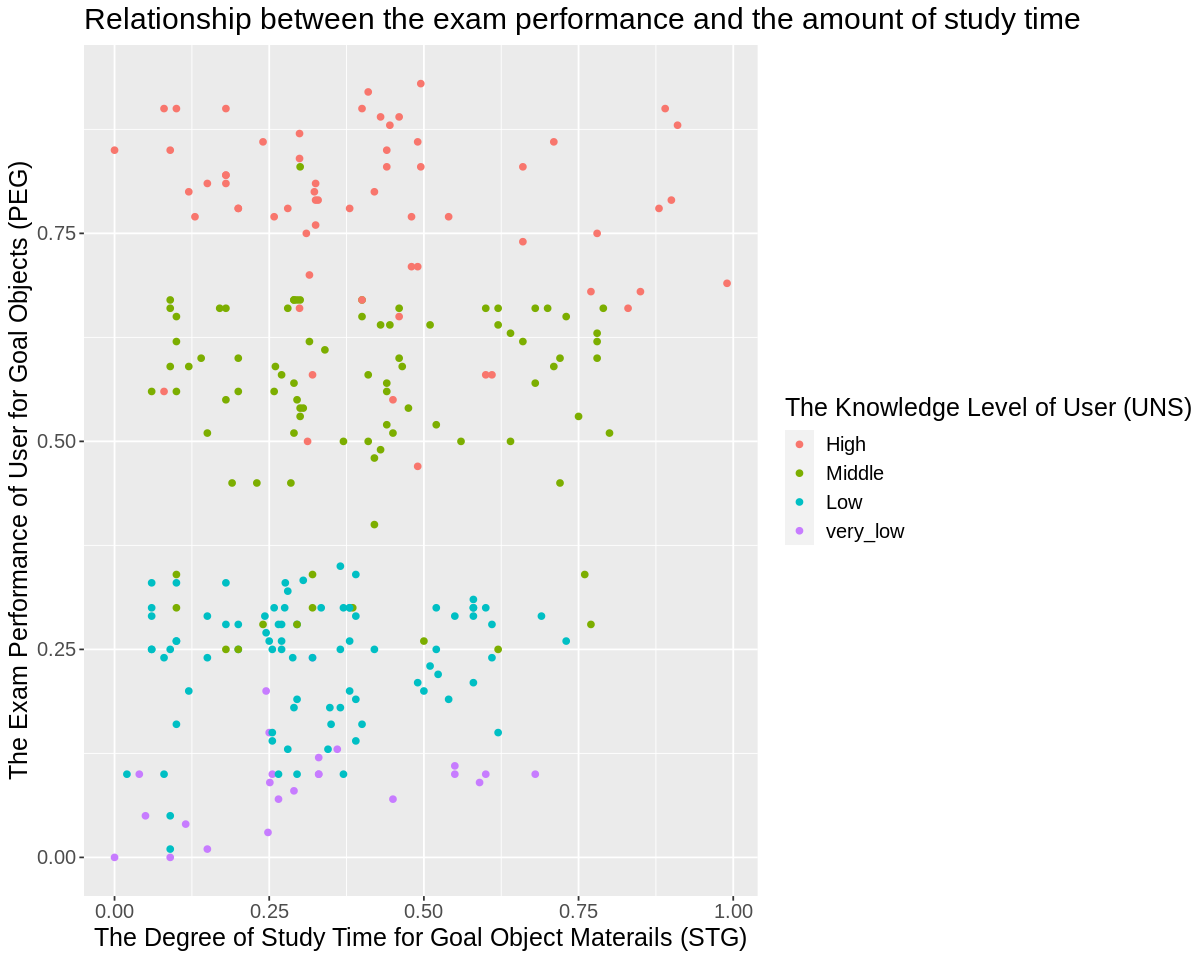

In [124]:
training_data_plot <- training_data|>
    mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low")))|>
    ggplot(aes(x=STG, y=PEG, colour = UNS)) +
    geom_point() +
    xlab("The Degree of Study Time for Goal Object Materails (STG)") +
    ylab("The Exam Performance of User for Goal Objects (PEG)") +
    labs(title = "Relationship between the exam performance and the amount of study time ", colour = "The Knowledge Level of User (UNS)")+
    theme(text = element_text(size = 15)) 

options(repr.plot.width = 10, repr.plot.height = 8)
training_data_plot

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



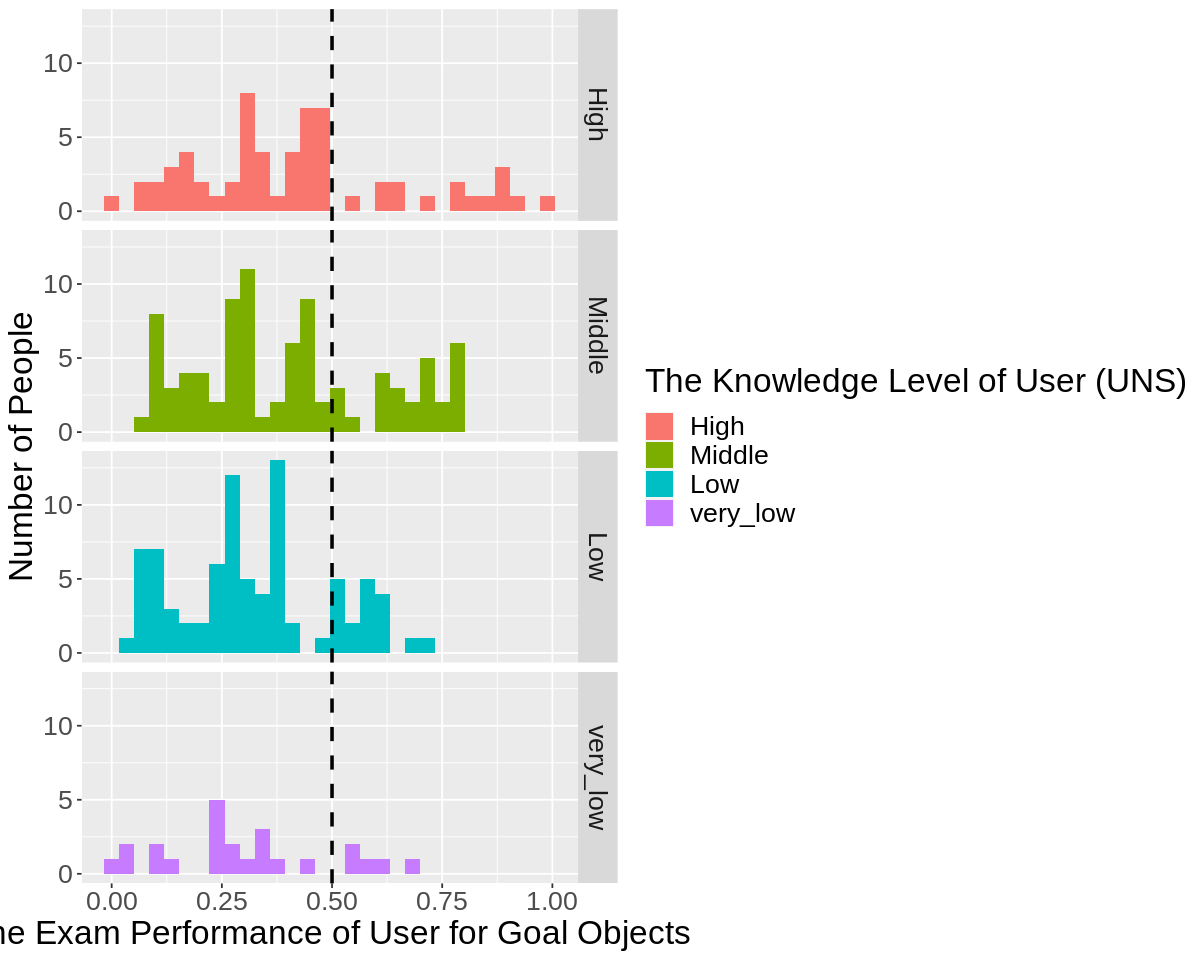

In [125]:
PEG_hist <- training_data|>
     mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low")))|>
    ggplot( aes(x = STG, fill = as_factor(UNS))) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.5, linetype = "dashed", size = 1.0) +
    labs(x = "The Exam Performance of User for Goal Objects", y = "Number of People", fill = "The Knowledge Level of User (UNS)") +
    theme(text = element_text(size = 20))
PEG_hist

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



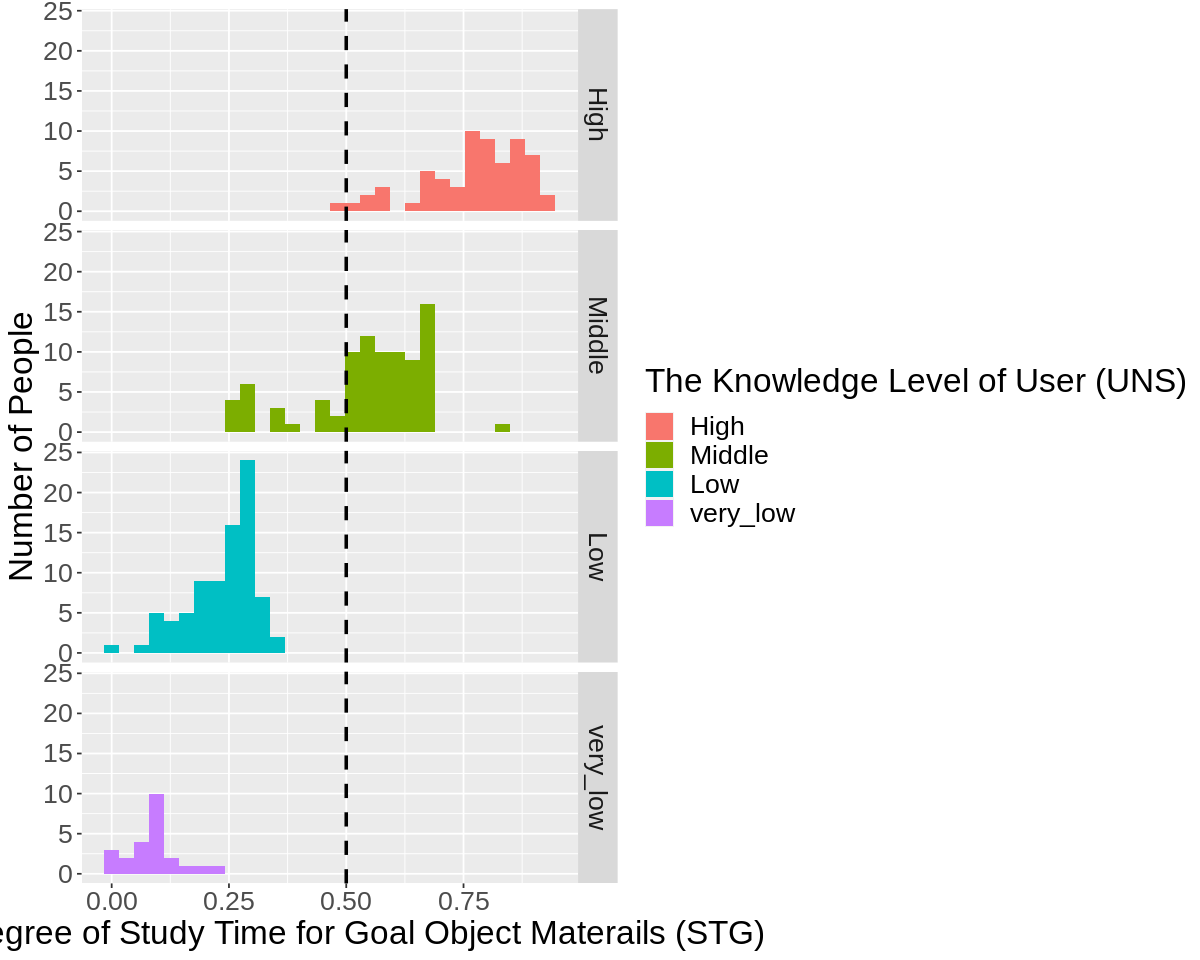

In [126]:
PEG_hist <- training_data|>
     mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low")))|>
    ggplot( aes(x = PEG, fill = as_factor(UNS))) +
    geom_histogram() +
    facet_grid(rows = vars(UNS)) +
    geom_vline(xintercept = 0.5, linetype = "dashed", size = 1.0) +
    labs(x = "The Degree of Study Time for Goal Object Materails (STG)", y = "Number of People", fill = "The Knowledge Level of User (UNS)") +
    theme(text = element_text(size = 20))
PEG_hist

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,multiclass,0.7778070,10,0.03828245,Preprocessor1_Model01
2,accuracy,multiclass,0.7725439,10,0.03925760,Preprocessor1_Model02
3,accuracy,multiclass,0.7780702,10,0.03858852,Preprocessor1_Model03
⋮,⋮,⋮,⋮,⋮,⋮,⋮
8,accuracy,multiclass,0.7828070,10,0.03483417,Preprocessor1_Model08
9,accuracy,multiclass,0.7878363,10,0.03569786,Preprocessor1_Model09
10,accuracy,multiclass,0.7878363,10,0.03569786,Preprocessor1_Model10


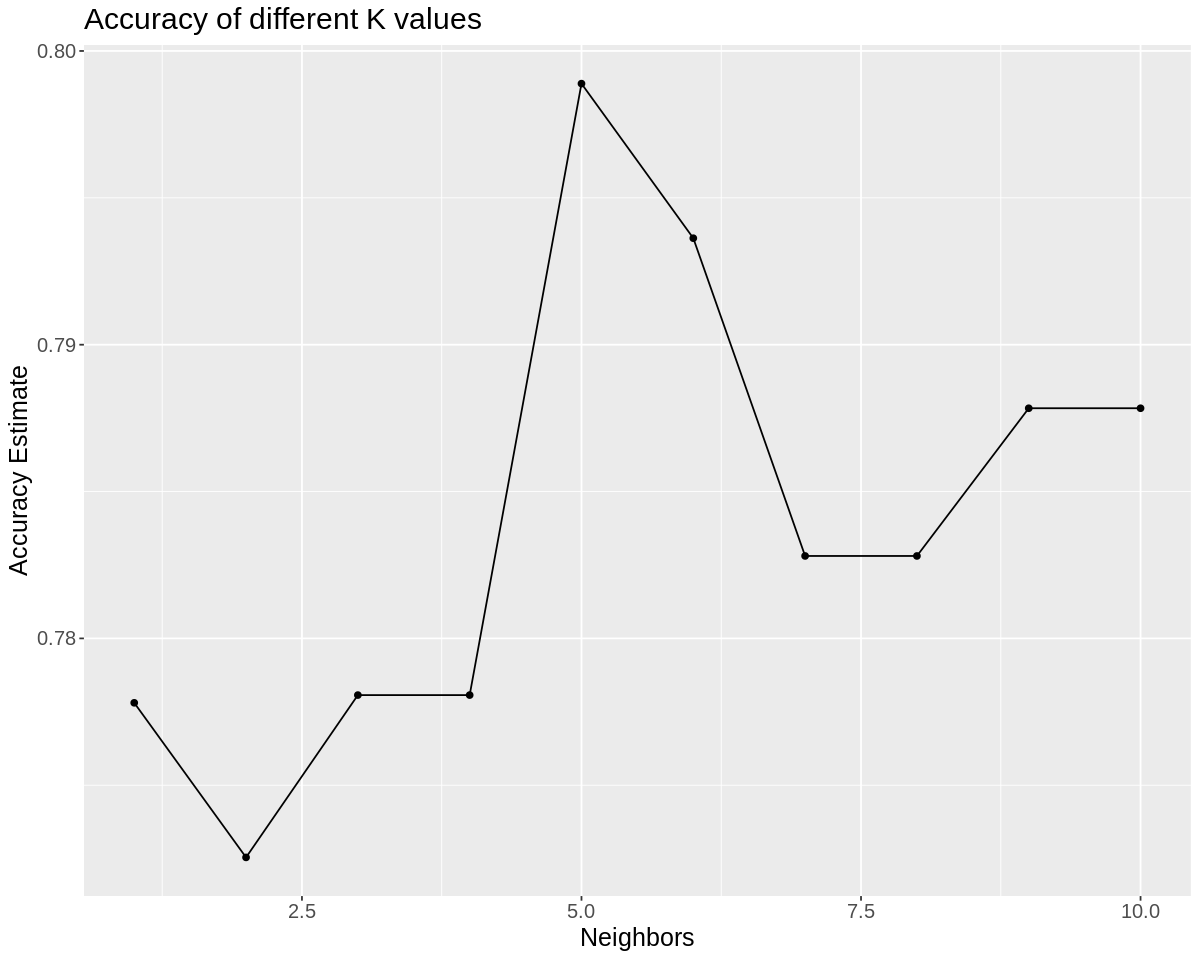

In [127]:
exam_data <- training_data |>
    mutate(UNS = as_factor(UNS))

## split into training and testing sets
set.seed(123)

exam_split <- initial_split(exam_data, prop = 0.75, strata = UNS)
exam_train <- training(exam_split)
exam_test <- testing(exam_split)


## tuning for K
set.seed(123)

exam_vfold <- vfold_cv(exam_train, v=10, strata = UNS)

exam_recipe <- recipe(UNS ~., data = exam_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

gridvals <- tibble(neighbors = seq(from=1, to=10, by=1))

knn_results <- workflow() |>
    add_recipe(exam_recipe) |>
    add_model(knn_spec) |>
    tune_grid(resamples = exam_vfold, grid = gridvals) |>
    collect_metrics() |>
    filter(.metric == "accuracy")

knn_results

## plot K values against their respective accuracies and choose optimal k value
cross_val_plot <- knn_results |>
    ggplot(aes(x = neighbors, y=mean)) +
    geom_point() +
    geom_line() +
    labs(x="Neighbors", y="Accuracy Estimate", title="Accuracy of different K values") +
    theme(text = element_text(size=15))
cross_val_plot
set.seed(123)

In [128]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
    set_engine("kknn") |>
    set_mode("classification")

exam_fit <- workflow() |>
    add_recipe(exam_recipe) |>
    add_model(knn_best_spec) |>
    fit(data=exam_train)

## get the prediction column
exam_prediction <- predict(exam_fit, exam_test) |>
    bind_cols(exam_test)
exam_prediction

## compare the accuracy of predictions to the true values in the test set 
exam_acc <- exam_prediction |>
    metrics(truth = UNS, estimate = .pred_class) |>
    select(.metric, .estimate) |>
    head(1)
exam_acc

.pred_class,STG,PEG,UNS
<fct>,<dbl>,<dbl>,<fct>
High,0.08,0.90,High
Low,0.06,0.33,Low
Low,0.10,0.30,Middle
⋮,⋮,⋮,⋮
High,0.89,0.90,High
Middle,0.72,0.45,Middle
Low,0.54,0.19,Low


.metric,.estimate
<chr>,<dbl>
accuracy,0.7878788


#### When doing the data analysis, it showed that the best neighbour with a 78.78% percent accuracy was 5. This was done using a classification model with a 5-fold cross validation. 

We chose k = 5 because this gave us the highest classification accuracy. It is also a good balance between a model that relies too much on the training data, which is overfitting; and a model that is not influenced enough by the training data, which is underfitting. Both overfitting and underfitting are problems as they reduce the accuracy of the classifier and result in incorrect predictions being made. For example, if we had picked k = 2, our model would have suffered from the problem of overfitting as changes in the training data would heavily influence the classification of a new observation. On the other hand, if we had picked k = 7, we would be encountering issues due to underfitting. Due to a increased number of k, the observation type with  

In [129]:
#compare the predictions to the true values in a confusion matrix
exam_cm <- exam_prediction |>
    conf_mat(truth = UNS, estimate = .pred_class)
exam_cm

          Truth
Prediction very_low High Low Middle
  very_low        1    0   4      0
  High            0   16   0      0
  Low             4    0  15      3
  Middle          0    2   1     20

We used the confusion matrix to test how good our model is when predicting each variable of UNS. When testing a new observation in our classification model, the model predicted 100% when the UNS was high, 80% of the time when the UNS was very low, 68% of the time when UNS was low and 87% of the time for the middle.

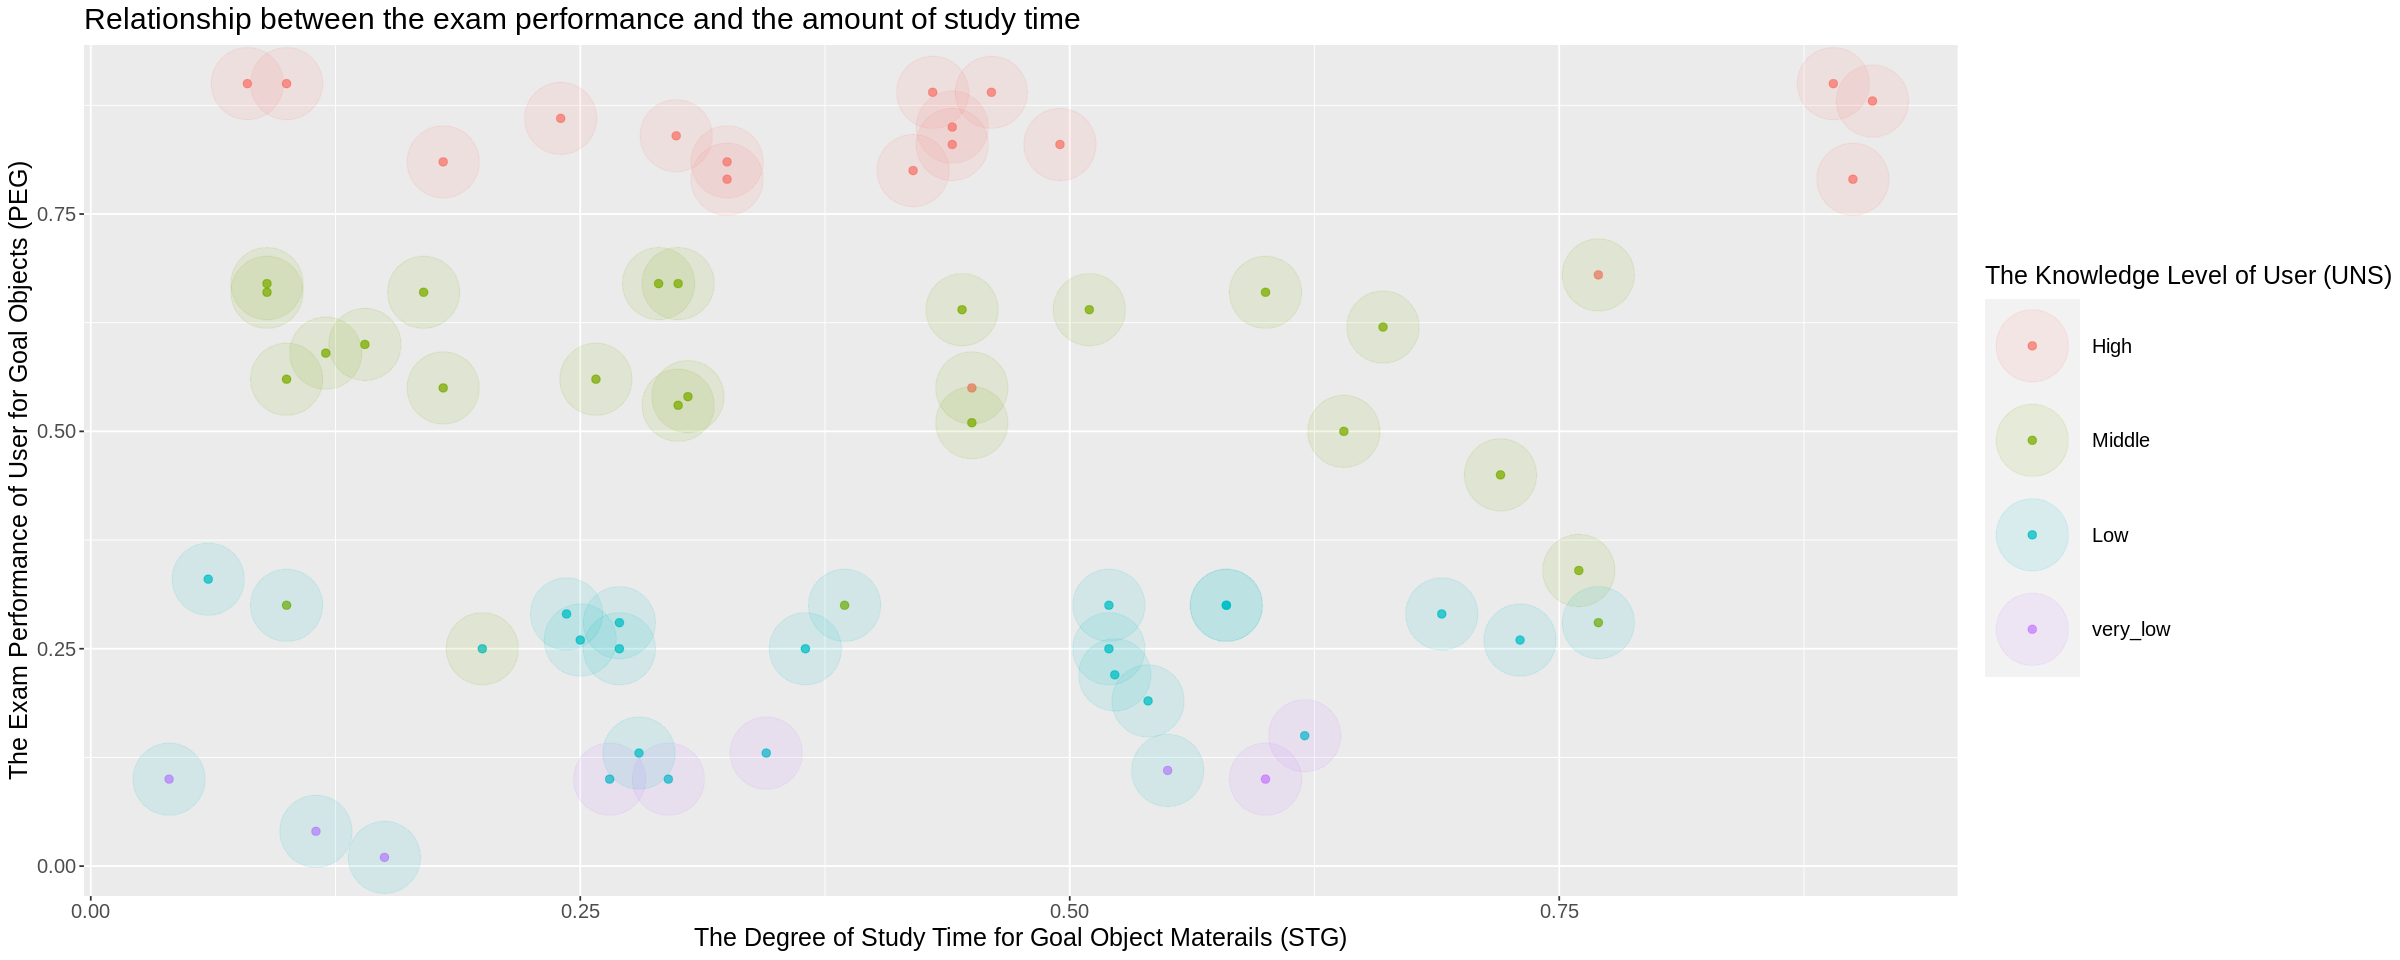

In [145]:
# bigger point -- predictions
# smaller points -- observations
accuracy_visualization <-exam_prediction|>
mutate(UNS = factor(UNS, levels = c("High", "Middle", "Low", "very_low")))|>
  ggplot() +
  geom_point(mapping = aes(x = STG, 
                           y = PEG, 
                           color = UNS), 
             alpha = 0.75,
             size = 2)+
  geom_point(mapping = aes(x = STG, 
                           y = PEG, 
                           color = .pred_class), 
             alpha = 0.1, 
             size = 20) +
    xlab("The Degree of Study Time for Goal Object Materails (STG)") +
    ylab("The Exam Performance of User for Goal Objects (PEG)") +
    labs(title = "Relationship between the exam performance and the amount of study time ", colour = "The Knowledge Level of User (UNS)")+
    theme(text = element_text(size = 15))

options(repr.plot.width = 20, repr.plot.height = 8)
accuracy_visualization

In [146]:
#The above image is an accuracy visualization plot of the testing dataset. 
#The larger points represent the predicted values, while the smaller points represent the actual values. 
#If the color of the larger point is different from the color of the smaller point, it indicates a prediction error.

# Discussion



# References

https://aatbs.com/blog/post/quality-over-quantity-3-ways-to-focus-your-studying#:~:text=The%20quantity%20of%20time%20and,will%20naturally%20learn%20the%20content.

https://www.keytostudy.com/quality-quantity-study-matters/

https://royalsocietypublishing.org/doi/full/10.1098/rstb.2017.0280

Barbarick, K.A. and Ippolito, J.A. (2003), Does the Number of Hours Studied Affect Exam Performance?. Journal of Natural Resources and Life Sciences Education, 32: 32-35. https://doi.org/10.2134/jnrlse.2003.0032


In [ ]:
#